# Notebook foroccupancy detection using WiFi interference (control data)

### much of this code and method has been sourced from comp47350 Data Analytics. Stackoverflow was referenced for support.

In [70]:
'''import packages'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pylab as pl
import statsmodels.formula.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score


wifiData = pd.read_csv('WiFi_Home.txt', sep=" ", header=None)
print(wifiData.shape)
wifiData.head(5)

(307, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,WiFi,signal,stength,at,12-08-2016,17:48,Link,Quality=58/70,NaN,Signal,level=-52,dBm,NaN,GT:1,D:2d
1,WiFi,signal,stength,at,12-08-2016,17:55,Link,Quality=56/70,NaN,Signal,level=-54,dBm,NaN,GT:1,D:2d
2,WiFi,signal,stength,at,12-08-2016,18:00,Link,Quality=55/70,NaN,Signal,level=-55,dBm,NaN,GT:1,D:2d
3,WiFi,signal,stength,at,12-08-2016,18:05,Link,Quality=55/70,NaN,Signal,level=-55,dBm,NaN,GT:1,D:2d
4,WiFi,signal,stength,at,12-08-2016,18:10,Link,Quality=57/70,NaN,Signal,level=-53,dBm,NaN,GT:1,D:2d


### Data cleaning

In [71]:
''' drop unneccessary colmns from the dataframe '''

wifiData.drop([0, 1, 2, 3, 6, 8, 9, 11, 12, 14],inplace=True,axis=1)
wifiData.head(5)

,4,5,7,10,13
0,12-08-2016,17:48,Quality=58/70,level=-52,GT:1
1,12-08-2016,17:55,Quality=56/70,level=-54,GT:1
2,12-08-2016,18:00,Quality=55/70,level=-55,GT:1
3,12-08-2016,18:05,Quality=55/70,level=-55,GT:1
4,12-08-2016,18:10,Quality=57/70,level=-53,GT:1


In [72]:
''' rename column headers '''

wifiData.rename(columns={4: 'date', 5: 'time', 7: 'quality', 10: 'level', 13: 'GT'}, inplace=True)
wifiData.head(5)

,date,time,quality,level,GT
0,12-08-2016,17:48,Quality=58/70,level=-52,GT:1
1,12-08-2016,17:55,Quality=56/70,level=-54,GT:1
2,12-08-2016,18:00,Quality=55/70,level=-55,GT:1
3,12-08-2016,18:05,Quality=55/70,level=-55,GT:1
4,12-08-2016,18:10,Quality=57/70,level=-53,GT:1


In [73]:
''' drop unneccessary text from cells '''

import re


def cleanLevel(x):
    myString = str(x)
    index = myString.index('=')
    newString = myString[index+1:] # last four characters
    #return int(newString)
    return int(newString)

def cleanQuality(x):
    myString = str(x)
    index = myString.index('/')
    indexStart = myString.index('=')
    total = myString[index+1:]
    level = myString[indexStart+1:index] # last four characters
    newString = int(level)/int(total) # return int(newString)
    percent = format(newString, '.2f')
    return percent

def cleanGT(x):
    myString = str(x)
    index = myString.index(':')
    newString = myString[index+1:]
    newInt = int(newString)
    return newInt


wifiData['level'] = wifiData['level'].apply(cleanLevel)
wifiData['quality'] = wifiData['quality'].apply(cleanQuality)
wifiData['GT'] = wifiData['GT'].apply(cleanGT)

wifiData.head(5)

,date,time,quality,level,GT
0,12-08-2016,17:48,0.83,-52,1
1,12-08-2016,17:55,0.80,-54,1
2,12-08-2016,18:00,0.79,-55,1
3,12-08-2016,18:05,0.79,-55,1
4,12-08-2016,18:10,0.81,-53,1


In [74]:
''' reset groundtruth to binary (0=unoccupied, 1=occupied) '''

def binaryGT(x):
    if x > 0:
        return 1
    else:
        return 0

wifiData['GT_binary'] = wifiData['GT'].apply(binaryGT)
wifiData['GT_binary'] = wifiData['GT_binary'].astype('category')
wifiData.head(5)
print('')
print(wifiData.dtypes)


date           object
time           object
quality        object
level           int64
GT              int64
GT_binary    category
dtype: object


In [75]:
''' add a column describing the absolute value of the level feature '''

def absoluteLevel(x):
    absol = abs(x)
    return absol


wifiData['abslevel'] = wifiData['level'].apply(absoluteLevel)
wifiData.head(5)

,date,time,quality,level,GT,GT_binary,abslevel
0,12-08-2016,17:48,0.83,-52,1,1,52
1,12-08-2016,17:55,0.80,-54,1,1,54
2,12-08-2016,18:00,0.79,-55,1,1,55
3,12-08-2016,18:05,0.79,-55,1,1,55
4,12-08-2016,18:10,0.81,-53,1,1,53


In [76]:
''' set quality to between 0-100 '''

def multiplyQual(x):
    return float(x) * 100

wifiData['quality'] = wifiData['quality'].apply(multiplyQual)
wifiData.head(5)

,date,time,quality,level,GT,GT_binary,abslevel
0,12-08-2016,17:48,83,-52,1,1,52
1,12-08-2016,17:55,80,-54,1,1,54
2,12-08-2016,18:00,79,-55,1,1,55
3,12-08-2016,18:05,79,-55,1,1,55
4,12-08-2016,18:10,81,-53,1,1,53


## Data inspection

In [77]:
''' print number of columns and rows in dataframe '''

print(wifiData.shape)
print('')
wifiData.head(7)

(307, 7)



,date,time,quality,level,GT,GT_binary,abslevel
0,12-08-2016,17:48,83,-52,1,1,52
1,12-08-2016,17:55,80,-54,1,1,54
2,12-08-2016,18:00,79,-55,1,1,55
3,12-08-2016,18:05,79,-55,1,1,55
4,12-08-2016,18:10,81,-53,1,1,53
5,12-08-2016,18:15,84,-51,1,1,51
6,12-08-2016,18:20,76,-57,1,1,57


In [78]:
wifiData.tail(7)

,date,time,quality,level,GT,GT_binary,abslevel
300,13-08-2016,18:51,80,-54,1,1,54
301,13-08-2016,18:56,83,-52,1,1,52
302,13-08-2016,19:01,80,-54,1,1,54
303,13-08-2016,19:06,79,-55,1,1,55
304,13-08-2016,19:11,83,-52,1,1,52
305,13-08-2016,19:16,80,-54,1,1,54
306,13-08-2016,19:21,86,-50,1,1,50


In [79]:
print(wifiData.dtypes)

date           object
time           object
quality       float64
level           int64
GT              int64
GT_binary    category
abslevel        int64
dtype: object


In [80]:
''' print the colilations between the features '''

corrilatedwifiData = wifiData.corr()
corrilatedwifiData

,quality,level,GT,abslevel
quality,1.000000,0.998593,-0.658563,-0.998593
level,0.998593,1.000000,-0.661177,-1.000000
GT,-0.658563,-0.661177,1.000000,0.661177
abslevel,-0.998593,-1.000000,0.661177,1.000000


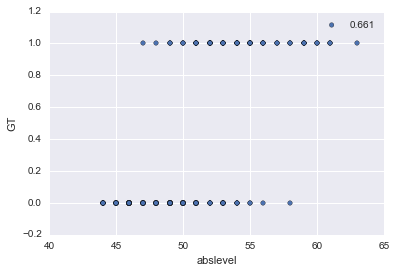

In [81]:
%matplotlib inline
wifiData.plot(kind='scatter', x='abslevel', y='GT', label="%.3f" % wifiData[['abslevel', 'GT']].corr().as_matrix()[0,1])

## logarithmic model, this modeling process was chosen to remain consistant with the other models used in the project

In [83]:
''' shuffle the rows so training and test sets are random '''

wifiData = wifiData.reindex(np.random.permutation(wifiData.index))
print(wifiData.head(15))

           date   time  quality  level  GT GT_binary  abslevel
110  13-08-2016  03:00       87    -49   0         0        49
256  13-08-2016  15:11       86    -50   0         0        50
55   12-08-2016  22:25       77    -56   1         1        56
196  13-08-2016  10:11       90    -47   0         0        47
268  13-08-2016  16:11       84    -51   0         0        51
19   12-08-2016  19:25       84    -51   0         0        51
185  13-08-2016  09:15       90    -47   0         0        47
3    12-08-2016  18:05       79    -55   1         1        55
14   12-08-2016  19:00       84    -51   1         1        51
263  13-08-2016  15:46       87    -49   0         0        49
93   13-08-2016  01:35       81    -53   0         0        53
160  13-08-2016  07:10       91    -46   0         0        46
258  13-08-2016  15:21       86    -50   0         0        50
75   13-08-2016  00:05       80    -54   0         0        54
282  13-08-2016  17:21       86    -50   1         1   

In [84]:
'''Prepare an intercept term that adds a 1 to each example. Scikit-learn does not use an intercept by default.'''

intercept = pd.DataFrame({'Intercept': np.ones(len(wifiData.index))})
print(intercept.shape)
intercept.head(10)

(307, 1)


,Intercept
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [85]:
'''Prepare the descriptive features'''

X = pd.concat([intercept, wifiData[['abslevel', 'quality']]], axis=1)
y = wifiData.GT_binary
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
      Intercept  abslevel  quality
0            1        52       83
1            1        54       80
2            1        55       79
3            1        55       79
4            1        53       81
5            1        51       84
6            1        57       76
7            1        61       70
8            1        61       70
9            1        53       81
10           1        58       74
11           1        63       67
12           1        59       73
13           1        60       71
14           1        51       84
15           1        52       83
16           1        50       86
17           1        50       86
18           1        51       84
19           1        51       84
20           1        53       81
21           1        53       81
22           1        54       80
23           1        53       81
24           1        52       83
25           1        52       83
26           1        52       83
27           1        52 

In [86]:
''' Train a model using logistic regression. '''

#logreg = LogisticRegression().fit(X, y)
logreg = LogisticRegression().fit(X[['Intercept', 'abslevel', 'quality']], y)

In [87]:
'''Examine the estimated logistic regression coefficients.'''

#pd.DataFrame(zip(X[['Size']], np.transpose(logreg.coef_)))
print("Coeficients: \n", logreg.coef_)

Coeficients: 
 [[-0.00017367 -0.0177956  -0.00303875]]


In [88]:
'''Predicted probabilities for each example. The output is a pair for each example, The first component is the probability of 
    the negative class (class 0). The second component is the probability of the positive class (class 1).'''

#logreg.predict_proba(y)
logreg.predict_proba(X[['Intercept', 'abslevel', 'quality']])

array([[ 0.76457618,  0.23542382],
       [ 0.76930824,  0.23069176],
       [ 0.77191677,  0.22808323],
       [ 0.77191677,  0.22808323],
       [ 0.76667889,  0.23332111],
       [ 0.76190959,  0.23809041],
       [ 0.7765444 ,  0.2234556 ],
       [ 0.78559775,  0.21440225],
       [ 0.78559775,  0.21440225],
       [ 0.76667889,  0.23332111],
       [ 0.77857117,  0.22142883],
       [ 0.79002331,  0.20997669],
       [ 0.78110476,  0.21889524],
       [ 0.78310172,  0.21689828],
       [ 0.76190959,  0.23809041],
       [ 0.76457618,  0.23542382],
       [ 0.75977737,  0.24022263],
       [ 0.75977737,  0.24022263],
       [ 0.76190959,  0.23809041],
       [ 0.76190959,  0.23809041],
       [ 0.76667889,  0.23332111],
       [ 0.76667889,  0.23332111],
       [ 0.76930824,  0.23069176],
       [ 0.76667889,  0.23332111],
       [ 0.76457618,  0.23542382],
       [ 0.76457618,  0.23542382],
       [ 0.76457618,  0.23542382],
       [ 0.76457618,  0.23542382],
       [ 0.78310172,

In [89]:
'''Check the accuracy on the training set. The accuracy is the ratio of correct predictions to total examples. Total accuracy 
    is then 0.72 or 72% accuracy.'''

predictions = logreg.predict(X[['Intercept', 'abslevel', 'quality']])
logreg.score(X[['Intercept', 'abslevel', 'quality']], y)

0.75895765472312704

In [90]:
''' Some more evaluation metrics. '''

print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  0.758957654723
Confusion matrix: 
 [[233   0]
 [ 74   0]]
Classification report:
               precision    recall  f1-score   support

          0       0.76      1.00      0.86       233
          1       0.00      0.00      0.00        74

avg / total       0.58      0.76      0.65       307



C:\Users\barry\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Normalize features and retrain model

In [91]:
''' quality is a value between 1 and 100 but this value never drops below 75 (53/70) so all values between the min and the max 
    have been normalised to range between -1 and 1 '''

wifiData['GT_norm'] = wifiData['GT']
wifi_des_feat = wifiData[['quality', 'abslevel', 'GT_norm']]

wifi_norm = (wifi_des_feat - wifi_des_feat.min()) / (wifi_des_feat.max() - wifi_des_feat.min())
wifi_norm = wifi_norm * 2 - 1

wifiData = pd.concat([wifiData.date, wifiData.time, wifi_norm, wifiData.GT, wifiData.GT_binary], axis=1)
wifiData.head(5)

,date,time,quality,abslevel,GT_norm,GT,GT_binary
110,13-08-2016,03:00,0.481481,-0.473684,-1,0,0
256,13-08-2016,15:11,0.407407,-0.368421,-1,0,0
55,12-08-2016,22:25,-0.259259,0.263158,1,1,1
196,13-08-2016,10:11,0.703704,-0.684211,-1,0,0
268,13-08-2016,16:11,0.259259,-0.263158,-1,0,0


In [92]:
''' Prepare the descriptive features '''

X = pd.concat([intercept, wifiData[['quality', 'abslevel']]], axis=1)
y = wifiData.GT_binary
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
      Intercept   quality  abslevel
0            1  0.185185 -0.157895
1            1 -0.037037  0.052632
2            1 -0.111111  0.157895
3            1 -0.111111  0.157895
4            1  0.037037 -0.052632
5            1  0.259259 -0.263158
6            1 -0.333333  0.368421
7            1 -0.777778  0.789474
8            1 -0.777778  0.789474
9            1  0.037037 -0.052632
10           1 -0.481481  0.473684
11           1 -1.000000  1.000000
12           1 -0.555556  0.578947
13           1 -0.703704  0.684211
14           1  0.259259 -0.263158
15           1  0.185185 -0.157895
16           1  0.407407 -0.368421
17           1  0.407407 -0.368421
18           1  0.259259 -0.263158
19           1  0.259259 -0.263158
20           1  0.037037 -0.052632
21           1  0.037037 -0.052632
22           1 -0.037037  0.052632
23           1  0.037037 -0.052632
24           1  0.185185 -0.157895
25           1  0.185185 -0.157895
26           1  0.185185 -0.1578

In [93]:
''' Split the data into train and test sets. Take a third (random) data samples as test data, rest as training data '''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1))
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

In [94]:
''' Train on the training sample and test on the test sample. '''

logreg_train = LogisticRegression().fit(X_train, y_train)
print(logreg_train.coef_)

[[-0.60316513  0.11005774 -0.04115942]]


In [95]:
''' Estimated class probabilities on test set'''

print(logreg_train.predict_proba(X_test))

[[ 0.75883956  0.24116044]
 [ 0.7565474   0.2434526 ]
 [ 0.76484896  0.23515104]
 [ 0.74413987  0.25586013]
 [ 0.74804931  0.25195069]
 [ 0.74804931  0.25195069]
 [ 0.74175554  0.25824446]
 [ 0.75883956  0.24116044]
 [ 0.76484896  0.23515104]
 [ 0.7565474   0.2434526 ]
 [ 0.76259605  0.23740395]
 [ 0.7565474   0.2434526 ]
 [ 0.75883956  0.24116044]
 [ 0.77655379  0.22344621]
 [ 0.77075385  0.22924615]
 [ 0.7565474   0.2434526 ]
 [ 0.75883956  0.24116044]
 [ 0.75883956  0.24116044]
 [ 0.74804931  0.25195069]
 [ 0.74413987  0.25586013]
 [ 0.74413987  0.25586013]
 [ 0.76484896  0.23515104]
 [ 0.75883956  0.24116044]
 [ 0.76259605  0.23740395]
 [ 0.76259605  0.23740395]
 [ 0.78436758  0.21563242]
 [ 0.75272623  0.24727377]
 [ 0.74804931  0.25195069]
 [ 0.74804931  0.25195069]
 [ 0.75883956  0.24116044]
 [ 0.75039508  0.24960492]
 [ 0.7565474   0.2434526 ]
 [ 0.74175554  0.25824446]
 [ 0.74804931  0.25195069]
 [ 0.75272623  0.24727377]
 [ 0.74804931  0.25195069]
 [ 0.74804931  0.25195069]
 

In [96]:
predicted = logreg_train.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

0.752688172043


## Model evaluation using cross-validation (several out-of-sample datasets)

In [97]:
''' Evaluate the model using 10-fold cross-validation. Uses 2 thirds of data for training and the last third for testing. 
    This process is repeated 10 times. '''

scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.75        0.75        0.75        0.74193548  0.76666667  0.76666667
  0.76666667  0.76666667  0.76666667  0.76666667]
0.759193548387
